### Agenda:
1. Data Loading & Preprocessing
   - Pivoting
   - Missing values handling
   - Date features creation
   - Train/Test split
   - Scaling
   - Sequences
   - Data Loader (incl. indexing for Basisformer)
2. Benchmark Models
   - Linear Regression
   - LSTM
3. Transformers
   - Non-Stationary Autoformer
   - BasisFormer
   - iTransformer
   - Chronos
4. Experimental Design
   - Device Setup (probably can be eliminated)
   - Data Preparation
   - Unification
5. Results
6. Outlook
   - Chronos Simulation Framework
   - DYNOTEARS Causal Structure
   - Non linear causal structure
   - Data Augmentation


In [1]:
#!pip install torch==2.0.1

# 1. Data Loading & Preprocessing

In [2]:
import torch

In [3]:
import pandas as pd
import numpy as np

In [4]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.utils.weight_norm as wn
import torch.nn.functional as F

In [5]:
from sklearn.preprocessing import StandardScaler
import argparse
import os
import logging
import time
import importlib

In [6]:
#from torch.utils.tensorboard import SummaryWriter

In [7]:
##file_path = '/content/all_countries.csv' ## colab path
file_path = 'data/all_countries.csv' ## jupyter path
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Austria,AUT,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Austria,AUT,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Austria,AUT,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Austria,AUT,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Austria,AUT,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


In [8]:
df = df [['Country','Datetime (UTC)',  'Price (EUR/MWhe)']]
df = df.pivot(index='Datetime (UTC)', columns='Country', values='Price (EUR/MWhe)')
df.head()

Country,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland
Datetime (UTC),,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,17.93,34.94,NaN,NaN,24.20,18.29,23.37,23.37,34.94,17.93,...,27.36,17.18,48.10,44.17,NaN,24.20,23.25,48.10,23.37,43.43
2015-01-01 01:00:00,15.17,32.19,NaN,NaN,22.06,16.04,19.33,19.33,32.19,15.17,...,27.24,17.38,47.33,39.17,NaN,22.06,22.20,47.33,19.33,38.08
2015-01-01 02:00:00,16.38,28.05,NaN,NaN,20.27,14.60,17.66,17.66,23.53,16.38,...,27.16,17.40,42.27,26.93,NaN,20.27,19.56,42.27,17.66,35.47
2015-01-01 03:00:00,17.38,28.04,NaN,NaN,19.17,14.95,17.53,17.53,22.92,17.38,...,27.15,18.60,38.41,20.94,NaN,19.17,18.88,38.41,17.53,30.83
2015-01-01 04:00:00,16.38,34.26,NaN,NaN,17.90,14.50,18.07,18.07,34.26,16.38,...,27.30,19.30,35.72,18.52,NaN,17.90,18.39,35.72,18.07,28.26


In [9]:
print(df.isnull().sum())

Country
Austria                0
Belgium                0
Bulgaria           15336
Croatia            24096
Czechia                0
Denmark                0
Estonia                0
Finland                0
France                 0
Germany                0
Greece                 0
Hungary                0
Ireland            12480
Italy                  0
Latvia                 0
Lithuania              0
Luxembourg             0
Netherlands            0
North Macedonia    73008
Norway                 0
Poland                 0
Portugal               0
Romania                0
Serbia             16800
Slovakia               0
Slovenia               0
Spain                  0
Sweden                 0
Switzerland            0
dtype: int64


In [10]:
df = df.dropna(axis=1)
print(df.isnull().sum())

Country
Austria        0
Belgium        0
Czechia        0
Denmark        0
Estonia        0
Finland        0
France         0
Germany        0
Greece         0
Hungary        0
Italy          0
Latvia         0
Lithuania      0
Luxembourg     0
Netherlands    0
Norway         0
Poland         0
Portugal       0
Romania        0
Slovakia       0
Slovenia       0
Spain          0
Sweden         0
Switzerland    0
dtype: int64


In [11]:
df.reset_index(inplace=True)
df.columns.name = None
print(df.head())

        Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  Finland  \
0  2015-01-01 00:00:00    17.93    34.94    24.20    18.29    23.37    23.37   
1  2015-01-01 01:00:00    15.17    32.19    22.06    16.04    19.33    19.33   
2  2015-01-01 02:00:00    16.38    28.05    20.27    14.60    17.66    17.66   
3  2015-01-01 03:00:00    17.38    28.04    19.17    14.95    17.53    17.53   
4  2015-01-01 04:00:00    16.38    34.26    17.90    14.50    18.07    18.07   

   France  Germany  Greece  ...  Netherlands  Norway  Poland  Portugal  \
0   34.94    17.93   48.78  ...        34.94   27.36   17.18     48.10   
1   32.19    15.17   31.10  ...        32.19   27.24   17.38     47.33   
2   23.53    16.38   20.78  ...        28.05   27.16   17.40     42.27   
3   22.92    17.38   25.40  ...        28.04   27.15   18.60     38.41   
4   34.26    16.38   26.00  ...        34.26   27.30   19.30     35.72   

   Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
0    44.17   

In [12]:
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
last_time_point = df['Datetime (UTC)'].max()
print("Last time point available:", last_time_point)

Last time point available: 2024-04-30 23:00:00


In [13]:
start_date = '2024-02-01 01:00:00' ## FILTERING ONLY FOR 3 MONTHS
df = df[df['Datetime (UTC)'] >= pd.to_datetime(start_date)]
print(df)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
79633 2024-02-01 01:00:00    66.59    44.47    80.01    30.49    26.71   
79634 2024-02-01 02:00:00    64.13    45.15    80.01    31.12    38.22   
79635 2024-02-01 03:00:00    69.80    49.02    80.01    31.95    27.71   
79636 2024-02-01 04:00:00    80.78    57.56    87.10    35.01    20.10   
79637 2024-02-01 05:00:00    86.95    70.56    95.00    39.04    72.59   
...                   ...      ...      ...      ...      ...      ...   
81787 2024-04-30 19:00:00    87.82    87.02    88.29    66.05    88.36   
81788 2024-04-30 20:00:00    77.50    75.39    77.99    54.09    78.02   
81789 2024-04-30 21:00:00    76.10    77.51    75.93    50.98    54.93   
81790 2024-04-30 22:00:00    64.22    58.00    67.16    44.71    38.00   
81791 2024-04-30 23:00:00    54.89    54.28    56.35    44.18    36.61   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
79633    -2.49   46.66    42.16   

In [14]:
df['month'] = df['Datetime (UTC)'].apply(lambda row: row.month)
df['day'] = df['Datetime (UTC)'].apply(lambda row: row.day)
df['weekday'] = df['Datetime (UTC)'].apply(lambda row: row.weekday())
df['hour'] = df['Datetime (UTC)'].apply(lambda row: row.hour)

print(df.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
79633 2024-02-01 01:00:00    66.59    44.47    80.01    30.49    26.71   
79634 2024-02-01 02:00:00    64.13    45.15    80.01    31.12    38.22   
79635 2024-02-01 03:00:00    69.80    49.02    80.01    31.95    27.71   
79636 2024-02-01 04:00:00    80.78    57.56    87.10    35.01    20.10   
79637 2024-02-01 05:00:00    86.95    70.56    95.00    39.04    72.59   

       Finland  France  Germany  Greece  ...  Romania  Slovakia  Slovenia  \
79633    -2.49   46.66    42.16   80.00  ...    80.00     91.00     71.73   
79634    -2.50   47.04    43.05   73.06  ...    73.06     80.19     67.66   
79635    -2.07   51.06    46.91   83.80  ...    83.80     96.02     75.10   
79636    -1.84   59.82    55.34   99.57  ...    99.57    116.13     87.74   
79637    -0.10   72.42    69.01  107.36  ...   107.36    108.87     95.63   

       Spain  Sweden  Switzerland  month  day  weekday  hour  
79633  55.10   -2.49        7

In [15]:
# separating the electricity prices and timestamp features
electricity_prices_df = df[['Datetime (UTC)', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']]
timestamp_features_df = df[['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']]

# defining the split ratio
train_size = 0.8
train_size_electricity = int(len(electricity_prices_df) * train_size)
train_size_timestamp = int(len(timestamp_features_df) * train_size)

# spliting the data into train and test sets
electricity_prices_train = electricity_prices_df[:train_size_electricity]
electricity_prices_test = electricity_prices_df[train_size_electricity:]
timestamp_features_train = timestamp_features_df[:train_size_timestamp]
timestamp_features_test = timestamp_features_df[train_size_timestamp:]

In [16]:
#print(electricity_prices_train.head())

In [17]:
#country_names = electricity_prices_train.drop(columns=['Datetime (UTC)']).columns.tolist()

In [18]:
# rescaling the electricity prices
scaler = StandardScaler()

electricity_prices_train_scaled = scaler.fit_transform(electricity_prices_train.drop(columns=['Datetime (UTC)']))
electricity_prices_test_scaled = scaler.transform(electricity_prices_test.drop(columns=['Datetime (UTC)']))

In [19]:
#electricity_prices_train_scaled

In [20]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = [] # storing for input seqiences
    seq_y = [] # storing for output seqiences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "ns_autoformer"]:
          seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        else: ## only chronos
          seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

In [21]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)
    
    if curr_model == "basis_former":
        indices = []
        total_len = len(seq_x)
        for i in range(total_len):
            index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
            norm_index = index_list / total_len
            indices.append(norm_index)
        indices = torch.tensor(indices, dtype=torch.float32)
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices)
    else:
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
    return dataloader

# 2. Benchmark Models

## 2.1. Linear Regression

## 2.2. LSTM

# 3. Transformers

## Chronos

zero shot evaluation with Chronos Pretrained Model

In [30]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = []  # storing for input sequences
    seq_y = []  # storing for output sequences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "ns_autoformer"]:
            seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        elif curr_model == "chronos":
            # For Chronos, we only need the input sequence
            seq_y.append(data[i+seq_length])  # Single step forecast
        else:
            seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

In [31]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)
    
    if curr_model == "basis_former":
        indices = []
        total_len = len(seq_x)
        for i in range(total_len):
            index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
            norm_index = index_list / total_len
            indices.append(norm_index)
        indices = torch.tensor(indices, dtype=torch.float32)
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices)
    elif curr_model == "chronos":
        # For Chronos, we only need the input sequence (seq_x)
        dataset = TensorDataset(seq_x.reshape(seq_x.shape[0], -1))  # Flatten the input sequence
    else:
        dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
    return dataloader

In [36]:
# Function to prepare data for Chronos
def prepare_chronos_data(dataloader):
    chronos_data = []
    for batch in dataloader:
        chronos_data.append(batch[0])  # Only take the first element (seq_x)
    return torch.cat(chronos_data, dim=0)

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="mps",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


# Example usage
seq_length = 24
pred_length = 12
label_length = 12
batch_size = 32
countries = electricity_prices_train.columns.drop('Datetime (UTC)').tolist()
seq_x_mark = timestamp_features_df.iloc[:len(electricity_prices_train)].drop(columns=['Datetime (UTC)']).values
seq_y_mark = timestamp_features_df.iloc[len(electricity_prices_train):].drop(columns=['Datetime (UTC)']).values


# Assume you have your data prepared as before
# data, seq_x_mark, seq_y_mark = ...

results = {}

for country in countries:
    # Extract data for the current country
    country_data = electricity_prices_train_scaled[:, electricity_prices_train.columns.get_loc(country)]
    
    seq_x, seq_y = create_sequences(country_data, seq_length, pred_length, label_length, "chronos")
    dataloader = create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, "chronos")
    
    # Prepare data for Chronos
    chronos_input = prepare_chronos_data(dataloader)
    
    # Now you can use chronos_input with your Chronos pipeline
    # Assuming you have a Chronos pipeline already set up
    forecast = pipeline.predict(
        context=chronos_input,
        prediction_length=pred_length,
        num_samples=20,
    )
    
    # Store the forecast results
    results[country] = forecast
    
    print(f"Completed forecast for {country}")

/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RuntimeError: MPS backend out of memory (MPS allocated: 8.33 GB, other allocations: 4.66 MB, max allowed: 9.07 GB). Tried to allocate 812.50 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
from typing import Dict, List

def create_country_tensors(data: np.ndarray, timestamps: pd.DataFrame, sequence_length: int) -> Dict[str, List[torch.Tensor]]:
    country_tensors = {}
    
    for i in range(data.shape[1]):  # Iterate through each country column
        country_data = data[:, i]
        
        # Create sequences
        X = []
        for j in range(len(country_data) - sequence_length):
            X.append(country_data[j:j+sequence_length])
        
        # Convert to tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Create timestamp tensor
        timestamp_tensor = torch.tensor(timestamps.iloc[sequence_length:].values, dtype=torch.float32)
        
        country_tensors[f"Country_{i}"] = [X_tensor, timestamp_tensor]
    
    return country_tensors

# Define sequence length
sequence_length = 24  # Adjust as needed

# Create tensors for training data
train_tensors = create_country_tensors(
    electricity_prices_train_scaled, 
    timestamp_features_df.iloc[:train_size_timestamp], 
    sequence_length
)

# Create tensors for test data
test_tensors = create_country_tensors(
    electricity_prices_test_scaled, 
    timestamp_features_df.iloc[train_size_timestamp:], 
    sequence_length
)

# Function to predict using Chronos for a single country
def predict_chronos(pipeline, country_data, prediction_length, num_samples):
    forecast = pipeline.predict(
        context=country_data[0],  # Use the price data tensor
        prediction_length=prediction_length,
        num_samples=num_samples,
    )
    return forecast

# Loop through each country and make predictions
results = {}
for country, tensors in train_tensors.items():
    # Assuming you have a Chronos pipeline already set up
    forecast = predict_chronos(pipeline, tensors, prediction_length=12, num_samples=20)
    results[country] = forecast

In [23]:
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git
import chronos

In [24]:
batch_size = 8
seq_length = 48 # one week
pred_length = 48 # two days ahead
label_length = 48
curr_model = "chronos"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [25]:
print("Sample testing sequence x:", test_seq_x[0])

Sample testing sequence x: [[-1.47514259 -1.49006706 -1.56686779 ... -0.29106655 -1.84177497
  -0.90996892]
 [-1.67138901 -1.71409752 -1.76082611 ... -0.49449098 -1.76060728
  -1.31408237]
 [-1.66016387 -1.79509619 -1.74650184 ... -0.60904395 -1.71469425
  -1.39936291]
 ...
 [ 0.65492464 -0.15813289  0.81173485 ... -0.29613526 -1.88891783
   0.61635889]
 [ 0.53802835 -0.37781708  0.56860945 ... -0.62391218 -1.953688
   0.39492022]
 [ 0.5388025  -0.51887329  0.50318239 ... -0.76076749 -1.95204825
   0.20836905]]


In [26]:
# Check the dimensions
for batch in test_loader:
    batch_x, batch_y, batch_x_mark, batch_y_mark = batch
    print(f'Input batch shape: {batch_x.shape}')
    print(f'Output batch shape: {batch_y.shape}')
    print(f'Input mark shape: {batch_x_mark.shape}')
    print(f'Output mark shape: {batch_y_mark.shape}')
    break 

Input batch shape: torch.Size([8, 48, 24])
Output batch shape: torch.Size([8, 48, 24])
Input mark shape: torch.Size([8, 48, 4])
Output mark shape: torch.Size([8, 48, 4])


In [29]:
from chronos import ChronosPipeline
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            

In [ ]:
for batch in test_loader:
    print(batch)
    break  # Print only the first batch and break

1. Pad Sequences to the Same Length: Ensure all sequences within a batch have the same length.
2. Flatten the Padded Sequences: Convert the 3D tensor [batch_size, seq_length, num_features] to a 2D tensor [total_sequences, seq_length * num_features].

In [28]:
import torch
from torch.utils.data import DataLoader

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,  # Change to torch.float16 if necessary
)


# padding sequences within a batch
def pad_sequence(sequences, batch_first=True, padding_value=torch.nan):
    return torch.nn.utils.rnn.pad_sequence(sequences, batch_first=batch_first, padding_value=padding_value)

def pad_batch(batch):
    input_ids = batch[0]
    sequences = [input_ids[i] for i in range(input_ids.size(0))]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences

context = []

# Iterate over the DataLoader to extract and pad input_ids
for batch in test_loader:
    input_ids_padded = pad_batch(batch)
    context.append(input_ids_padded)

# Concatenate the padded tensors to form a 3D tensor
context_tensor_3d = torch.cat(context, dim=0)  # Concatenate along the batch dimension

# Flatten the 3D tensor to 2D
batch_size, seq_length, num_features = context_tensor_3d.shape
context_tensor_2d = context_tensor_3d.view(batch_size, -1)

# Now you can use the context tensor with your pipeline
print(context_tensor_2d.shape)  # To verify the shape


NameError: name 'ChronosPipeline' is not defined

This transformation suggests that each batch of size 24 (sequences) with 96 time steps and 24 features per time step has been flattened into a single 2D tensor.

Original Shape:
Batch size: 24
Sequence length: 96
Number of features: 24

Flattened Shape Calculation:
Flattened feature size: 96×24=2304
Total number of sequences (batches) after concatenation: 16200


The pipeline will process each of these 16,200 sequences, each with 2,304 features.

In [ ]:
del context
del context_tensor_3d

# predictions
# 1 hour of running for 2 months
forecast = pipeline.predict(
    context=context_tensor_2d,
    prediction_length=48,
    num_samples=1,
)

In [ ]:
forecast

In [ ]:
# Convert the forecast to a numpy array
forecast_np = forecast[0].numpy()

# Check the shape of forecast_np
print(forecast_np.shape)  # This should print (num_samples, prediction_length)

In [ ]:
forecast_reshaped = forecast_np.flatten()  # Flatten to (48,)
forecast_reshaped = forecast_reshaped.reshape(-1, 1)  # Reshape to (48, 1)
print(forecast_reshaped.shape) 

In [ ]:
rescaled_forecast = (forecast_reshaped * scaler.scale_[0]) + scaler.mean_[0]
rescaled_forecast = rescaled_forecast.reshape(forecast_np.shape)
print(rescaled_forecast.shape)  # Should print (1, 48)

In [ ]:
forecast_index = range(len(electricity_prices_test_scaled), len(electricity_prices_test_scaled) + 48)

# Compute quantiles for the forecast
low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(range(len(electricity_prices_test_scaled)), electricity_prices_test_scaled, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Electricity Prices')
plt.title('Electricity Prices Forecast')
plt.show()

## Basisformer

### Data preparation

In [ ]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


In [ ]:
print("Sample training sequence x:", train_seq_x[0])
print("Sample training sequence y:", train_seq_y[0])
print("Sample training sequence x mark:", train_seq_x_mark[0])
print("Sample training sequence y mark:", train_seq_y_mark[0])

In [ ]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [ ]:
for batch in train_loader:
    print(f"Batch contains {len(batch)} items:")
    for i, item in enumerate(batch):
        print(f"Item {i}: Shape = {item.shape if torch.is_tensor(item) else 'Not a tensor'}")
    break  # Just print the first batch

In [ ]:
##pip install adabelief_pytorch==0.2.1

### Model Structure

In [ ]:
import importlib

import Basisformer.model
importlib.reload(Basisformer.model)
from Basisformer.model import Basisformer

import Basisformer.main
importlib.reload(Basisformer.main)
from Basisformer.main import parse_args, model_setup, log_and_print

args = parse_args()

# Set up device
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

# Set up model
model = model_setup(args, device)

# Log arguments and model
log_and_print('Args in experiment:')
log_and_print(args)
log_and_print(model)

### Train

In [ ]:
import Basisformer.model
importlib.reload(Basisformer.model)
from Basisformer.model import Basisformer

import Basisformer.main
importlib.reload(Basisformer.main)
from Basisformer.main import train


record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                          'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))

# Call the train function
train(model, train_loader, args, device, record_dir)


### Test

In [ ]:
import Basisformer.main
importlib.reload(Basisformer.main)
from Basisformer.main import test

test(model, test_loader, args, device, record_dir)

In [ ]:
basisformer_train = train
basisformer_test = test

## iTransformer

In [ ]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "itransformer"
batch_size = 24

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [ ]:
# print("Sample training sequence x:", train_seq_x[0])
# print("Sample training sequence y:", train_seq_y[0])
# print("Sample training sequence x mark:", train_seq_x_mark[0])
# print("Sample training sequence y mark:", train_seq_y_mark[0])

In [ ]:
for batch in train_loader:
    print(f"Batch contains {len(batch)} items:")
    for i, item in enumerate(batch):
        print(f"Item {i}: Shape = {item.shape if torch.is_tensor(item) else 'Not a tensor'}")
    break  # Just print the first batch

In [ ]:
import importlib
# Commented out because model is imported in experiment.py
# import iTransformer.Model 
# importlib.reload(iTransformer.Model)
# from iTransformer.Model import Model, Config

# Commented because both the imported functions are throwing errors
import iTransformer.main
importlib.reload(iTransformer.main)
from iTransformer.main import parse_args_itrans, long_term_forecast

import iTransformer.experiment
importlib.reload(iTransformer.experiment)
from iTransformer.experiment import Exp_Long_Term_Forecast

In [ ]:
class Args:
    is_training = 1
    model_id = 'iTransformer_train'
    model = 'iTransformer'
    data = 'all_countries'
    features = 'M'
    target = 'OT'
    freq = 'h'
    checkpoints = './checkpoints/'
    seq_len = 96
    label_len = 48
    pred_len = 48
    enc_in = 24
    dec_in = 24
    c_out = 24
    d_model = 512
    n_heads = 8
    e_layers = 2
    d_layers = 1
    d_ff = 2048
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.05
    embed = 'timeF'
    activation = 'gelu'
    output_attention = False
    do_predict = True
    num_workers = 10
    itr = 2
    train_epochs = 1
    batch_size = 32
    patience = 3
    learning_rate = 0.0001
    des = 'test'
    loss = 'mse'
    lradj = 'type1'
    use_amp = False
    use_gpu = True if torch.cuda.is_available() else False
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    exp_name = 'MTSF'
    channel_independence = False
    inverse = False
    class_strategy = 'projection'
    target_root_path = './data'
    target_data_path = 'all_countries'
    efficient_training = False
    use_norm = True
    partial_start_index = 0
    seed = 2021
    p_hidden_dims = [128, 128]
    p_hidden_layers = 2

args = Args()

if args.use_gpu:
    if args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]
    else:
        torch.cuda.set_device(args.gpu)

# Initialize the experiment
exp = Exp_Long_Term_Forecast(args) #long_term_forecast(args) #, train_loader, test_loader)

# Define the settings
setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
    args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
    args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
    args.factor, args.embed, args.distil, args.des, 0)

### Train

In [ ]:
Exp_Long_Term_Forecast.train(self=exp, train_loader=train_loader, setting=setting)

### Test

In [ ]:
Exp_Long_Term_Forecast.test(self=exp, test_loader=test_loader, setting=setting, test=0)

In [ ]:
# itransformer_train = Exp_Long_Term_Forecast.train()
# itransformer_test = Exp_Long_Term_Forecast.test()

## Nonstationary Transformer

In [ ]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "ns_autoformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [ ]:
for batch in train_loader:
    print(f"Batch contains {len(batch)} items:")
    for i, item in enumerate(batch):
        print(f"Item {i}: Shape = {item.shape if torch.is_tensor(item) else 'Not a tensor'}")
    break  # Just print the first batch

In [ ]:
import importlib

import ns_Autoformer.ns_Autoformer
importlib.reload(ns_Autoformer.ns_Autoformer)
from ns_Autoformer.ns_Autoformer import Model

import ns_Autoformer.main
importlib.reload(ns_Autoformer.main)
from ns_Autoformer.main import parse_args

In [ ]:
# from ns_Autoformer.main import Exp_Main

# setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
#     args.model_id, args.model, args.features, args.seq_len, args.label_len,
#     args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
#     args.factor, args.embed, args.distil, args.des, 0)

# exp = Exp_Main(args)

In [ ]:
from ns_Autoformer.main import Exp_Main

class Args:
    is_training = 1
    model_id = 'ns_autoformer_train'
    model = 'ns_Autoformer'
    features = 'M'
    target = 'OT'
    freq = 'h'
    checkpoints = './checkpoints/'
    seq_len = 96
    label_len = 48
    pred_len = 48
    enc_in = 24
    dec_in = 24
    c_out = 24
    d_model = 512
    n_heads = 8
    e_layers = 2
    d_layers = 1
    d_ff = 2048
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.05
    embed = 'timeF'
    activation = 'gelu'
    output_attention = False
    do_predict = True
    num_workers = 10
    itr = 2
    train_epochs = 1
    batch_size = 32
    patience = 3
    learning_rate = 0.0001
    des = 'test'
    loss = 'mse'
    lradj = 'type1'
    use_amp = False
    use_gpu = True if torch.cuda.is_available() else False
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    seed = 2021
    p_hidden_dims = [128, 128]
    p_hidden_layers = 2

args = Args()

if args.use_gpu:
    if args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]
    else:
        torch.cuda.set_device(args.gpu)

print('Args in experiment:')
print(args)

# Initialize the experiment
exp = Exp_Main(args)

# Define the setting string
setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
    args.model_id, args.model, args.features, args.seq_len, args.label_len,
    args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
    args.factor, args.embed, args.distil, args.des, 0)

In [ ]:
from ns_Autoformer.main import Exp_Main

Exp_Main.train(self=exp, train_loader=train_loader, setting=setting)

In [ ]:
Exp_Main.test(self=exp, test_loader=test_loader, setting=setting, test=0)

In [ ]:
ns_autoformer_train = Exp_Main.train
ns_autoformer_test = Exp_Main.test

# 4. Experimental Design

## Device Setup

In [22]:
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")

## Data Preparation

In [23]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


In [24]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/ipykernel_34711/2035128206.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608635429/work/torch/csrc/utils/tensor_new.cpp:277.)
  indices = torch.tensor(indices, dtype=torch.float32)


## Unification

In [25]:
def fit (model, train_flag, test_flag, train_loader=None, test_loader=None, pretrained_model=None):
    '''Fits a transformer model to the train and/or test loaders
    
    model - "basis_former", "itransformer", "ns_autoformer"
    
    train_flag: typ(bool) - True: to train the model on train_loader, False: if pretrained_model is passed
    
    test_flag: typ(bool) - True: to test on test_loader, False: if only training
    
    pretrained_model - pass a pretrained model if available to be fitted on a test_loader. 
    eg. fit(basis_former, train_flag=False, test_flag=True, test_loader=test_loader, pretrained_model=model)
    '''
    
    if curr_model == 'basis_former':
        # Code for Basisforme

        import Basisformer.model
        importlib.reload(Basisformer.model)
        from Basisformer.model import Basisformer

        import Basisformer.main
        importlib.reload(Basisformer.main)
        from Basisformer.main import parse_args, model_setup, log_and_print

        args = parse_args()
        
        if pretrained_model == None:
            # Set up model
            model = model_setup(args, device)

        else:
            model = pretrained_model

        # Log arguments and model
        log_and_print('Args in experiment:')
        log_and_print(args)
        log_and_print(model)
        
        if train_flag:
            import Basisformer.model
            importlib.reload(Basisformer.model)
            from Basisformer.model import Basisformer

            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import train


            record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                                    'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))
            
            if train_loader == None:
                return 'train_loader not found'

            # Call the train function
            train(model, train_loader, args, device, record_dir)
            
        else:
            if pretrained_model == None:
                return 'model not found which is required for testing'
            
        if test_flag :
            import Basisformer.main
            importlib.reload(Basisformer.main)
            from Basisformer.main import test
            
            if test_loader == None:
                return 'test_loader not found'

            test(model, test_loader, args, device, record_dir)
        return model
            
    
    elif curr_model == 'itransformer':
        # code for itransformer
        
        import iTransformer.experiment
        importlib.reload(iTransformer.experiment)
        from iTransformer.experiment import Exp_Long_Term_Forecast
        
        from iTransformer import Model
        
        class Args:
            is_training = 1
            model_id = 'iTransformer_train'
            model = 'iTransformer'
            data = 'all_countries'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 1
            batch_size = 32
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            exp_name = 'MTSF'
            channel_independence = False
            inverse = False
            class_strategy = 'projection'
            target_root_path = './data'
            target_data_path = 'all_countries'
            efficient_training = False
            use_norm = True
            partial_start_index = 0
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()
        
        if pretrained_model == None:
            # Initialize the experiment
            exp = Exp_Long_Term_Forecast(args)

        else:
            return 'pretrained not valid for iTransformer and ns_autoformer'

        # Define the settings
        setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.data, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)
        
        if train_flag:
            Exp_Long_Term_Forecast.train(self=exp, train_loader=train_loader, setting=setting)
        
        if test_flag:
            Exp_Long_Term_Forecast.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model
    
    elif curr_model == 'ns_autoformer':
        # code for itransformer
        import ns_Autoformer.ns_Autoformer
        importlib.reload(ns_Autoformer.ns_Autoformer)
        from ns_Autoformer.ns_Autoformer import Model

        # import ns_Autoformer.main
        # importlib.reload(ns_Autoformer.main)
        # from ns_Autoformer.main import parse_args
        
        from ns_Autoformer.main import Exp_Main

        class Args:
            is_training = 1
            model_id = 'ns_autoformer_train'
            model = 'ns_Autoformer'
            features = 'M'
            target = 'OT'
            freq = 'h'
            checkpoints = './checkpoints/'
            seq_len = 96
            label_len = 48
            pred_len = 48
            enc_in = 24
            dec_in = 24
            c_out = 24
            d_model = 512
            n_heads = 8
            e_layers = 2
            d_layers = 1
            d_ff = 2048
            moving_avg = 25
            factor = 1
            distil = True
            dropout = 0.05
            embed = 'timeF'
            activation = 'gelu'
            output_attention = False
            do_predict = True
            num_workers = 10
            itr = 2
            train_epochs = 1
            batch_size = 32
            patience = 3
            learning_rate = 0.0001
            des = 'test'
            loss = 'mse'
            lradj = 'type1'
            use_amp = False
            use_gpu = True if torch.cuda.is_available() else False
            gpu = 0
            use_multi_gpu = False
            devices = '0,1,2,3'
            seed = 2021
            p_hidden_dims = [128, 128]
            p_hidden_layers = 2

        args = Args()

        # if args.use_gpu:
        #     if args.use_multi_gpu:
        #         args.devices = args.devices.replace(' ', '')
        #         device_ids = args.devices.split(',')
        #         args.device_ids = [int(id_) for id_ in device_ids]
        #         args.gpu = args.device_ids[0]
        #     else:
        #         torch.cuda.set_device(args.gpu)

        # print('Args in experiment:')
        # print(args)

        # Initialize the experiment
        exp = Exp_Main(args)

        # Define the setting string
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
            args.model_id, args.model, args.features, args.seq_len, args.label_len,
            args.pred_len, args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
            args.factor, args.embed, args.distil, args.des, 0)
        
        if train_flag:
            Exp_Main.train(self=exp, train_loader=train_loader, setting=setting)
        
        if test_flag:
            Exp_Main.test(self=exp, test_loader=test_loader, setting=setting, test=0)
        return exp.model

In [28]:
iTransformer_train_test = fit(model=curr_model, train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

Use CPU
Epoch: 1 cost time: 48.523653984069824
Epoch: 1, Steps: 65 | Train Loss: 0.7034816
Validation loss decreased (inf --> 0.703482).  Saving model ...
Updating learning rate to 0.0001
test shape: (12, 24, 48, 24) (12, 24, 48, 24)
test shape: (288, 48, 24) (288, 48, 24)
mse:1.3615845441818237, mae:0.847229540348053


/Users/ekaterinabasova/miniconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Args in experiment:
Namespace(is_training=True, data_path='data', device=0, num_workers=0, features='M', freq='h', seq_len=96, pred_len=48, heads=16, d_model=100, N=10, block_nums=2, bottleneck=2, map_bottleneck=20, train_epochs=1, batch_size=24, learning_rate=0.0005, tau=0.07, loss_weight_prediction=1.0, loss_weight_infonce=1.0, loss_weight_smooth=1.0, check_point='checkpoint', patience=5)
Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0-1): 2 x BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
          (value_projection): Linear(in_features=100, out_features=96, bias=True)
          (out_projection): Linear(in_features=96, out_features=100, bias=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (conv1_basis): Linear(in_featu

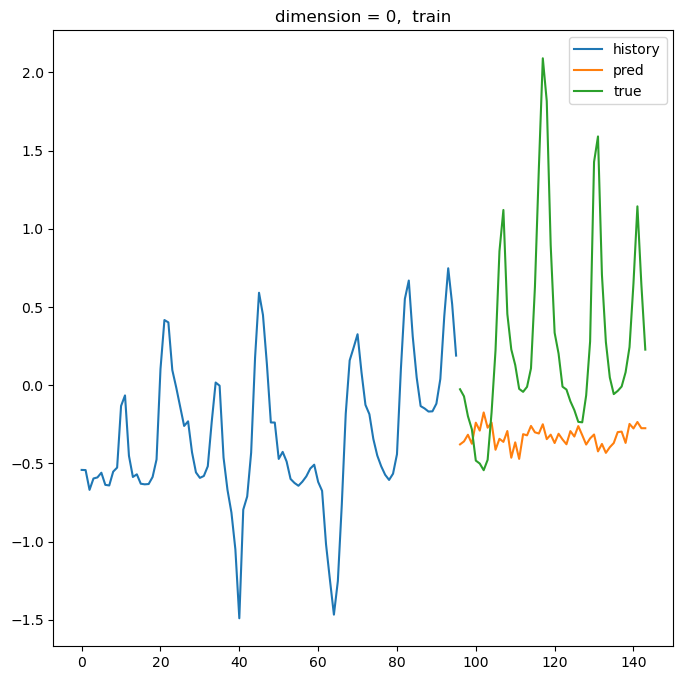

In [26]:
Basisformer_train_test = fit(model="basis_former", train_flag=True, test_flag=True, train_loader=train_loader, test_loader=test_loader)

# 5. Results - Models Performance Comparison

In [27]:
def run_models(model_name, train_loader, test_loader,  self, setting, args=None, device=None, record_dir=None):
    if model_name == "basisformer":
        basisformer_train(model_name, train_loader, args, device, record_dir)
        results = basisformer_test(model_name, test_loader, args, device, record_dir)
    elif model_name == "itransformer":
        itransformer_train(self, train_loader, setting)
        results = itransformer_test(self, test_loader, setting)
    elif model_name == "ns_autoformer":
        ns_autoformer_train(self, train_loader, setting)
        results = ns_autoformer_test(self, train_loader, setting)
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    
    return results

def compare_models(train_loader, test_loader, args, self, setting, device, record_dir):
    models = ["basisformer", "itransformer", "ns_autoformer"]
    results = {}
    
    for model_name in models:
        if model_name == "basisformer":
            results[model_name] = run_models(model_name, train_loader, test_loader, args, self, setting, device, record_dir)
        else:
            results[model_name] = run_models(model_name, train_loader, test_loader, self, setting)
    
    return results

In [28]:
results = compare_models(train_loader=train_loader, test_loader=test_loader, args=args, self=exp, setting=setting, device=None, record_dir=None, index=None)
print(results)

NameError: name 'args' is not defined

# 6. Outlook 

## Chronos Simulation

In [ ]:
!pip install "chronos[training] @ git+https://github.com/amazon-science/chronos-forecasting.git"

In [ ]:
!python supporting_files_chronos/kernel-synth.py --num-series 500 --max-kernels 2

In [ ]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch = table.to_pandas()

print(df_ch)

In [ ]:
import matplotlib.pyplot as plt 

# Number of time series
num_series = 15
# Number of plots per row
plots_per_row = 5
# Number of rows
num_rows = (num_series + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 3))

for i in range(num_series):
    row = i // plots_per_row
    col = i % plots_per_row
    ax = axes[row, col]
    ax.plot(df_ch['target'].iloc[i])
    ax.set_title(f'Time Series {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Remove any empty subplots
for j in range(i + 1, num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [ ]:
!python supporting_files_chronos/kernel-synth-mult.py --num-series 500 --max-kernels 2 --dimensions 3

In [ ]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch_mult = table.to_pandas()

print(df_ch_mult)

In [ ]:
print(df_ch_mult.head())
print(df_ch_mult['target'].head().apply(lambda x: np.array(x).shape))

In [ ]:
# Function to plot multivariate time series
def plot_multivariate_time_series(data, num_rows=3, num_cols=5):
    num_series = num_rows * num_cols
    time_points = np.arange(len(data[0]) // 3)  # 1024 time points for reshaped data
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axs = axs.flatten()  # Flatten to easily iterate over subplots
    
    for i in range(num_series):
        series = np.array(data[i]).reshape(-1, 3)  # Reshape to [1024, 3]
        for j in range(series.shape[1]):
            axs[i].plot(time_points, series[:, j], label=f'Dimension {j+1}')
        axs[i].set_title(f'Time Series {i+1}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Extract the 'target' column as a list and plot the first 15 multivariate time series
plot_multivariate_time_series(df_ch_mult['target'].head(15).tolist(), num_rows=3, num_cols=5)

## DYNOTEARS Causal Structure

In [ ]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [ ]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("supporting_files_dynotears/01_fully_connected.html")

In [ ]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

In [ ]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [ ]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

## Granger causality test with nonlinear forecasting methods

In [ ]:
!pip install nonlincausality

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  7 23:29:32 2022

@author: Maciej Rosoł

contact: mrosol5@gmail.com, maciej.rosol.dokt@pw.edu.pl
"""
#%%
import os

# os.chdir(os.path.dirname(__file__))
import numpy as np
##import tensorflow
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR

In [ ]:
#%% Data generation Y->X
np.random.seed(10)
y = (
    np.cos(np.linspace(0, 20, 10_100))
    + np.sin(np.linspace(0, 3, 10_100))
    - 0.2 * np.random.random(10_100)
)
np.random.seed(20)
x = 2 * y ** 3 - 5 * y ** 2 + 0.3 * y + 2 - 0.05 * np.random.random(10_100)
data = np.vstack([x[:-100], y[100:]]).T

plt.figure()
plt.plot(data[:, 0], label="X")
plt.plot(data[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

#%% Test in case of presence of the causality
lags = [50, 150]
data_train = data[:6000, :]
data_val = data[6000:8000, :]
data_test = data[8000:, :]


In [ ]:
results = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

In [ ]:
#%% Test in case of absence of the causality
np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)


#%% Example of usage for conditional analysis
np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])